In [2]:
# Autor: Daniel Pinto
# Introduccion a Grafos
# Fecha: 2021/10/06 YYYY/MM/DD
from typing import List, TypeVar, Tuple, Any, Callable, Optional, Generic, Dict
from hypothesis import given, strategies as st
from IPython.display import Markdown, display
from itertools import accumulate
from functools import reduce
from dataclasses import dataclass, field
from __future__ import annotations 
from copy import deepcopy
from collections.abc import  Iterable
import graphviz as gv
from abc import ABCMeta, abstractmethod


def display_(s : str) -> None:
    '''
    A way to display strings with markdown 
    in jupyter.
    '''
    display(
        Markdown(s)
    )


SUCCESS_COLOR = '#4BB543'
ERROR_COLOR   = '#B00020'

def color_text(s : str, color : str =SUCCESS_COLOR ) -> str:
    return f"<span style='color:{color}'> {s} </span>."


a      = TypeVar('a')
b      = TypeVar('b')
c      = TypeVar('c')
T      = TypeVar('T')

# Definicion de Grafo

Nosotros definiremos un Grafo $G$ como un contenedor el cual posee:


- Una (funcion) proyeccion $\pi_v : G \rightarrow V$ desde el grafo a un conjunto de vertices
- Una (funcion) proyeccion $\pi_e : G \rightarrow V \times V$ desde el Grafo al conjunto de aristas.
- Una funcion   $succ : V \rightarrow List[V]$ la cual asigna a cada vertice $v$ en el grafo una lista de vertices la cual tiene la propiedad:
  $v' \in succ(v) \iff (v,v') \in Im(\pi_e)$
- Una funcion   $pred : V \rightarrow List[V]$ la cual asigna a cada vertice $v$ en el grafo una lista de vertices la cual tiene la propiedad:
  $v' \in pred(v) \iff (v',v) \in Im(\pi_e)$
- Una (funcion) inyeccion $i_v : (V,G) \rightarrow G$, la cual inyecta un valor $v$ en el conjunto de vertices del grafo, es decir, satisface la propiedad:
  $v \in \pi_v (i_v (v,G))$
- Una (funcion) inyeccion $i_e : (V\times V, G) \rightarrow G$, la cual inyecta una arista $(v,v')$ en el conjunto de aristas en el grafo, es decir, satisface
  la propiedad: $(v,v') \in \pi_e (i_e ((v,v'),G))$
- Dos funciones de recorrido: $BFS$ y $DFS$ (por definir)

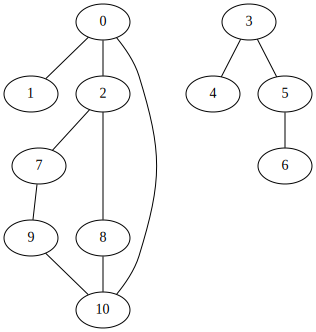

In [3]:
class AGraph(Generic[T], metaclass=ABCMeta):
    @abstractmethod
    def add_vertex(self,v : T) -> None:
        raise NotImplementedError

    @abstractmethod
    def add_edge(self,vs : Tuple[T,T]) -> None:
        raise NotImplementedError

    
    def add_vertices(self, vertices : Iterable[T]) -> None:
        for vertex in vertices:
            self.add_vertex(vertex)

    
    def add_edges(self, edges : Iterable[Tuple[T,T]]) -> None:
        for edge in edges:
            self.add_edge(edge)

    @abstractmethod
    def succs(self, v : T) -> List[T]:
        raise NotImplementedError

    @abstractmethod
    def preds(self, v : T) -> List[T]:
        raise NotImplementedError
    
    @abstractmethod
    def get_randV(self) -> T:
        raise NotImplementedError

    @abstractmethod
    def get_Vertices(self) -> set[T]:
        raise NotImplementedError

    @abstractmethod
    def get_Edges(self) -> set[Tuple[T,T]]:
        raise NotImplementedError

    
    def BFS_levels(self, iv : Optional[T] = None) -> Iterable[List[T]]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True

        while bool(mem) and change:
            change = False
            yield current
            for v in current:
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    def BFS(self, iv : Optional[T] = None) -> Iterable[T]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True

        while bool(mem) and change:
            change = False
            for v in current:
                yield v
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    
    def DFS(self, iv : Optional[T] = None) -> Iterable[T]:

        if iv is None:
            try:
                iv  = self.get_randV()
            except:
                return

        mem : set[T] = self.get_Vertices()

        def DFS_(v : T) -> Iterable[T] :
            mem.discard(v)
            yield v
            if not mem:
                return

            for succ in self.succs(v):
                if succ in mem:
                    for s in DFS_(succ):
                        yield s

        return DFS_(iv)

    
    def toPic(self) -> gv.Graph:
        raise NotImplementedError


@dataclass
class Graph(Generic[T],AGraph[T]):
    _Map         : Dict[T,int]   
    _adj_l       : List[List[T]]
    _i          : int 
    _is_directed : bool
    _is_weighted : bool
    _invMap      : Dict[int,T]
    _cost        : Dict[Tuple[T,T],float]

    def __init__(self, is_directed : bool = False, is_weighted : bool = False) -> None:
        self._Map         = {}
        self._invMap      = {}
        self._adj_l       = []
        self._i           = 0
        self._cost        = {}
        self._is_directed = is_directed
        self._is_weighted = is_weighted

    def add_vertex(self,v : T) -> None:
        if v in self._Map:
            return
        
        self._Map[v] = self._i
        self._adj_l.append([])
        self._invMap[self._i] = v
        self._i    += 1
    
    def _add_edge_dir(self, vs: Tuple[T, T]) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        
        i : int = self._Map[v]
        if s not in self._adj_l[i]:
            self._adj_l[i].append(s)
    
    def _add_edge_undir(self, vs: Tuple[T, T]) -> None:
        sv = (vs[1],vs[0])
        self._add_edge_dir(vs)
        self._add_edge_dir(sv)
    
    def _add_edge_cost_dir(self, vs: Tuple[T, T], cost : float) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        i : int = self._Map[v]
        if s in self._adj_l[i]:
            self._cost[vs] = cost
    
    def _add_edge_cost_undir(self, vs: Tuple[T, T], cost : float) -> None:
        sv = (vs[1],vs[0])
        self._add_edge_cost_dir(vs, cost)
        self._add_edge_cost_dir(sv, cost)


    def add_edge(self,vs : Tuple[T,T], cost : float = 0) -> None:
        if self._is_directed:
            self._add_edge_dir(vs)
        else:
            self._add_edge_undir(vs)
        
        if self._is_weighted:
            self._add_edge_cost_dir(vs,cost)
        else:
            self._add_edge_cost_undir(vs,cost)

    def add_cost_edges(self, edges : Iterable[Tuple[T,T,float]]) -> None:
        for (v,s,c) in edges:
            self.add_edge((v,s),c)

    def succs(self, v : T) -> List[T]:
        i : int = self._Map[v]
        return self._adj_l[i]
    
    def preds(self, v : T) -> List[T]:
        if not self._is_directed:
            return self.succs(v)
        
        res : List[T] = []
        for i in range(self._i):
            if v in self._adj_l[i]:
                res.append(self._invMap[i])
        return res

    def get_Vertices(self) -> set[T]:
        return set(self._Map.keys())
    
    def get_Edges(self) -> set[Tuple[T, T]]:
        s : set[Tuple[T, T]] = set()
        for v in self.get_Vertices():
            for v_ in self._adj_l[self._Map[v]]:
                if ((v_,v) in s) and (not self._is_directed):
                    pass
                else:
                    s.add((v,v_))

        return s

    def get_randV(self) -> T:
        from random import randint
        try:
            n : int = randint(0,len(self._adj_l)-1)
        except:
            raise ValueError
        
        return self._invMap[n]


    def _toPicDir(self) -> gv.Graph:
        g : gv.Graph = gv.Digraph()
        if not self._Map:
            return g

        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)

        return g
    
    def _toPicUnDir(self) -> gv.Graph:
        g : gv.Graph = gv.Graph()
        if not self._Map:
            return g
        
        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)
        
        return g

    def toPic(self) -> gv.Graph:
        if self._is_directed:
            return self._toPicDir()
        else:
            return self._toPicUnDir()
    
    def __deepcopy__(self) -> Graph[T]:
        g : Graph[T]   = Graph()
        g._Map         = deepcopy(self._Map)
        g._adj_l       = deepcopy(self._adj_l)
        g._i           = deepcopy(self._i)
        g._is_directed = deepcopy(self._is_directed)
        g._is_weighted = deepcopy(self._is_weighted)
        g._invMap      = deepcopy(self._invMap)
        g._cost        = deepcopy(self._cost)

        return g

g : Graph[int] = Graph(is_directed=False, is_weighted=False)

g.add_vertices([0,1,2,3,4,5,6,7,8,9,10])
g.add_edges([(0,1),(0,2),(5,6),(3,5),(10,9),(8,2),(2,0),(4,3),(7,2), (10,8), (10,0), (9,7)])


g.toPic()



# Exercise: Connected Component of an undirected Graph

Two vertices $v$ and $v'$ in a graph $G$ are **reachable** or **connected** if and only if there is a path from $v$ to $v'$.

A Connected component of an undirected graph $G=(V,E)$ consist of a subset of $U \subseteq V$ such that every pair in $(u,u') \in U \times U$ is reacachable.


Find all the connected components of $G$





In [4]:
#sol

def connected_comp(G : Graph[T]) -> List[Graph[T]]:
    
    to_be_visited : set[T] = G.get_Vertices()
    con_comp : List[Graph[T]] = []
    while (to_be_visited):
        
        v : T = to_be_visited.pop()
        print(list(G.DFS(v)))
        print(to_be_visited)
        vs : List[T] = [v]
        for u in G.DFS(v):
            if u in to_be_visited:
                vs.append(u)
                to_be_visited.remove(u)
        
        g : Graph[T] = Graph()
        g.add_vertices(vs)
        es : List[Tuple[T,T]] = []
        for s in vs:
            es += list(map(lambda x: (s,x),G.succs(s)))

        g.add_edges(es)
        con_comp.append(g)


    return con_comp

cc = connected_comp(g)
#cc[0].toPic().view(cleanup=True)
#cc[1].toPic().view(cleanup=True)

#list(map(lambda h: h.toPic().view(cleanup=True), cc))


[0, 1, 2, 8, 10, 9, 7]
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
[3, 5, 6, 4]
{4, 5, 6}


# Exercise: Number of Islands

Given an `m x n` 2D binary grid `grid` which represents a map of `'1'`s (land) and `'0'`s (water), return the number of islands.

An **island** is surrounded by water and is formed by connecting adjacent lands horizontally or vertically. You may assume all four edges of the grid are all surrounded by water.

# Examples:

```
Input: grid = [
  ["1","1","1","1","0"],
  ["1","1","0","1","0"],
  ["1","1","0","0","0"],
  ["0","0","0","0","0"]
]
Output: 1
```

```
Input: grid = [
  ["1","1","0","0","0"],
  ["1","1","0","0","0"],
  ["0","0","1","0","0"],
  ["0","0","0","1","1"]
]
Output: 3
```



In [5]:
# sol

# Exercise: Cycle detection

Given a graph `G` Determine if it has any cycles.


True


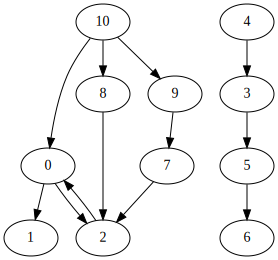

In [6]:
def has_cycle(G : Graph[T]) -> bool:
    

    mem : set[T] = G.get_Vertices()
    def DFS_(v : T, ancestors : set[T]) -> bool:
        mem.discard(v)
        if not mem:
            return False

        
        ancestors.add(v)
        cycle : bool = False
        for succ in G.succs(v):
            if succ in ancestors:
                return True 
            if succ in mem:
                cycle  = DFS_(succ,ancestors)
        
        ancestors.remove(v)

        return cycle
    while(mem):
        v = mem.pop()
        mem.add(v)
        if DFS_(v,set()):
            return True 
    return False

g : Graph[int] = Graph(is_directed=True, is_weighted=False)

g.add_vertices([0,1,2,3,4,5,6,7,8,9,10])
g.add_edges([(0,1),(0,2),(5,6),(3,5),(10,9),(8,2),(2,0),(4,3),(7,2), (10,8), (10,0), (9,7)])

print(has_cycle(g))
g.toPic()

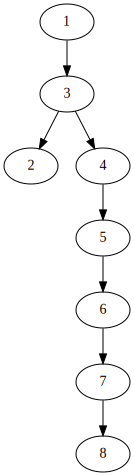

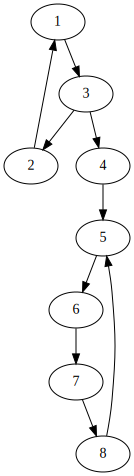

In [21]:
def tarjan_SCC(G : Graph[T], v : T) -> List[List[T]]:

    visit_num    : Dict[T,int]   = {}
    highest_pred : Dict[T,int]   = {}
    stack        : List[T]       = []
    mem          : set[T]        = G.get_Vertices()
    scc          : List[List[T]] = []
    def DFS_(v : T, i : int) -> None:
        
        if not mem:
            return


        visit_num[v]    = i
        highest_pred[v] = i
        stack.append(v)
        mem.remove(v)
        

        for u in G.succs(v):
            if u in mem:
                i += 1
                DFS_(u,i)
            
            highest_pred[v] = min(highest_pred[v],highest_pred[u])
        
        if visit_num[v] == highest_pred[v]:
            res : List[T] = []
            while visit_num[(u := stack.pop())] != visit_num[v]:
                res.append(u)

            res.append(v)
            scc.append(res)

    DFS_(v,1)
    return scc


def subgraph_gen_vertices(G : Graph[T], vs : List[T]) -> Graph[T]:
    G_ : Graph[T] = Graph(is_directed=True)
    G_.add_vertices(vs)
    edges : List[Tuple[T,T]] = []
    for v in vs:
        succs : List[T] = G.succs(v)
        edges += [(v,u) for u in succs if u in vs]

    G_.add_edges(edges)

    return G_

def dfs_tree(G : Graph[T], v : T) -> Graph[T]:
    vs  : List[T] = []
    mem : set[T]  = G.get_Vertices()
    es  : List[Tuple[T,T]] = [] 
    def DFS_(v : T) -> None:
        if not mem:
            return
        vs.append(v)
        mem.remove(v)

        for u in G.succs(v):
            if u in mem:
                es.append((v,u))
                DFS_(u)
    
    DFS_(v)
    G_ : Graph[T] = Graph(is_directed=G._is_directed)
    G_.add_vertices(vs)
    G_.add_edges(es)
    return G_
        
    



g : Graph[int] = Graph(is_directed=True)
g.add_vertices([1,2,3,4,5,6,7,8])
g.add_edges([(1,3),(3,4),(3,2),(2,1),(4,5),(5,6),(6,7),(7,8),(8,5)])

display(g.toPic())

display(dfs_tree(g,1).toPic())

scc = tarjan_SCC(g,1)
#print(scc)


#list(map(lambda vs: display(subgraph_gen_vertices(g,vs).toPic()), scc ))
